In [ ]:
#BA476: Using Binary Classification and Spotify Data to Predict Billboard Top 100 Placements
#Claire Choi, Rebecca Chang, Brett Rado, and Tristan Tew

import math
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA476/data/Manipulated_data.csv')
df = df.drop(["Unnamed: 0"], axis=1)
df.shape

(6344, 337)

# Data Pre-Processing

In [ ]:
#Break down all of the predictors into their respective categories
categorical_predictors = ["time_signature","key"
,"release_month","alb_type"]

#Choose these as poly features based on correlation matrix
poly_features = ["loudness","energy","acousticness",'instrumentalness']

#Create a df that has all predictors to do transformations on
all_predictors = df.loc[:, df.columns != 'target']

all_predictors

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,explicit,track_number,number_of_artists_on_song,release_month,genres_count,alb_type,album_tracks,pop,poprap,rap,dancepop,hiphop,trap,popdance,post-teenpop,southernhiphop,contemporarycountry,countryroad,country,atlhiphop,r&b,urbancontemporary,gangsterrap,moderncountryrock,edm,electropop,...,electricblues,azonto,frenchsoundtrack,viralrap,funkyhouse,christianrock,britpop,post-hardcore,epicdoom,calypso,classify,vaporsoul,australianindie,jazztrumpet,deeptalentshow,batonrougerap,reggaetoncolombiano,asmr,puertoricanpop,showtunes,punkblues,singer-songwriter,boombap,post-punk,easylistening,swedishjazz,exotica,candypop,bhangra,nuevoregionalmexicano,australiancountry,neo-classical,alternativecountry,symphonicblackmetal,progressivebluegrass,indiecoustica,soulfulhouse,position_on_album_ratio,duration_seconds,chorus_hit_percent
0,0.741,0.626,1,1.762331,0,11.286682,0.271442,0.000000,2.491327,0.7060,108.029,4,6.417695,2.397895,False,1.945910,1,11,8,album,2.639057,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.461538,5.239061,1.223156
1,0.447,0.247,5,2.751174,0,28.901734,0.955006,0.949852,2.358098,0.2500,155.489,3,5.760280,2.302585,False,2.302585,1,6,5,album,2.484907,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.818182,5.175472,1.194706
2,0.550,0.415,9,2.022474,0,19.230769,0.544012,0.000000,2.225624,0.2740,172.065,4,6.700110,2.302585,False,0.693147,1,9,3,single,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,5.325266,1.194706
3,0.502,0.648,0,1.901809,0,18.975332,0.172467,0.000000,1.589635,0.2910,91.837,4,5.433711,2.079442,True,1.098612,2,2,12,album,2.302585,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,5.262913,1.124748
4,0.482,0.873,0,1.421903,1,11.723329,0.223070,0.000000,0.894040,0.7370,165.084,4,5.672126,2.564949,True,1.098612,1,11,5,album,2.833213,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.125000,5.367470,1.271150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,0.172,0.358,9,2.736314,1,29.239766,0.960457,0.991389,1.158362,0.0361,72.272,4,4.930339,2.079442,False,1.609438,1,8,1,single,1.945910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.666667,5.016332,1.124748
6340,0.910,0.366,1,2.393705,1,10.626993,0.463539,0.000000,1.343235,0.7400,119.985,4,5.704258,2.197225,True,2.397895,1,12,7,album,2.833213,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.625000,5.023881,1.162283
6341,0.719,0.804,10,1.719368,1,28.169014,0.236333,0.041687,1.973281,0.6050,119.999,4,4.553428,2.079442,False,0.693147,1,3,4,album,2.995732,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.052632,5.428292,1.124748
6342,0.600,0.177,7,2.837323,1,17.825312,0.996320,0.965228,1.903809,0.5600,120.030,4,4.653279,2.708050,False,2.564949,3,8,13,album,2.772589,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.800000,5.363107,1.310506


In [ ]:
#Encode each of the features while maintaining understandable column names

#Iterate through each categorical predictor
for cat in categorical_predictors:

  #Add dummy variables to the predictor df for each categorical variable and assign appropriate labels
  all_predictors = pd.concat([all_predictors,pd.get_dummies(all_predictors[cat],prefix=cat)],axis=1)

  #Drop the original categorical column from the df
  all_predictors = all_predictors.drop(columns=cat)

#Instantiate polynomial features
poly= PolynomialFeatures(2, include_bias=False)

#Apply the polynomial fit to all columns and store them in their own df
df_poly = pd.DataFrame(poly.fit_transform(all_predictors[poly_features]))

#Assign labels to the polynomial features
df_poly.columns=poly.get_feature_names(all_predictors[poly_features].columns)

In [ ]:
#Drop the original variables for the poly features so there are no duplicates when df_poly and all_preds are merged
for pol in poly_features:

  #drop the poly columns
  df_poly = df_poly.drop(columns=pol)

#Create new df with all the labels
labelled_df = pd.concat([all_predictors,df_poly],axis=1)

In [ ]:
#Define X and y
X = labelled_df
y = df.loc[:,'target']

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
#Standardize the Data Using StandardScaler
scaler = StandardScaler() 
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

#Turn the scaled numbers back into a dataframe with labels
X_scaled_train = pd.DataFrame(X_scaled_train, columns=list(X.columns.values))
X_scaled_test = pd.DataFrame(X_scaled_test, columns=list(X.columns.values))

X_scaled_test

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,chorus_hit,sections,explicit,track_number,number_of_artists_on_song,genres_count,album_tracks,pop,poprap,rap,dancepop,hiphop,trap,popdance,post-teenpop,southernhiphop,contemporarycountry,countryroad,country,atlhiphop,r&b,urbancontemporary,gangsterrap,moderncountryrock,edm,electropop,melodicrap,canadianpop,poprock,rock,...,time_signature_3,time_signature_4,time_signature_5,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,release_month_1,release_month_2,release_month_3,release_month_4,release_month_5,release_month_6,release_month_7,release_month_8,release_month_9,release_month_10,release_month_11,release_month_12,alb_type_album,alb_type_compilation,alb_type_single,loudness^2,loudness energy,loudness acousticness,loudness instrumentalness,energy^2,energy acousticness,energy instrumentalness,acousticness^2,acousticness instrumentalness,instrumentalness^2
0,-0.280865,-0.017206,-0.125405,0.739974,0.371072,0.486624,-0.631018,-0.085578,-1.002805,1.932575,0.508149,-0.192166,-0.553986,-1.239569,-0.529180,-1.189111,-2.066205,-0.918954,0.0,-0.596464,0.0,0.0,-0.410498,0.0,0.0,0.0,0.0,0.0,-0.356368,0.0,-0.292478,0.0,0.0,0.0,-0.216863,-0.204626,0.0,0.0,0.0,-0.485425,...,-0.286079,0.326136,-0.126542,-0.360567,-0.383898,-0.300343,-0.193939,-0.264543,-0.289291,-0.290887,-0.342166,-0.308074,-0.282843,3.515380,-0.287688,2.595728,-0.295641,-0.247056,-0.281215,-0.301900,-0.292478,-0.257656,-0.257656,-0.297214,-0.318689,-0.343601,-0.321680,-1.452685,-0.383898,2.044405,-0.214387,0.111472,0.222370,-0.590587,-0.231583,0.896717,-0.518851,0.205548,-0.405061,-0.590436
1,1.567452,-0.193633,0.998643,0.739974,-1.404438,-0.304124,-0.580029,-0.481522,0.436463,-0.722873,1.018689,-0.192166,-0.553986,-1.239569,-0.529180,-0.904128,0.689694,-0.918954,0.0,1.676547,0.0,0.0,-0.410498,0.0,0.0,0.0,0.0,0.0,-0.356368,0.0,-0.292478,0.0,0.0,0.0,-0.216863,-0.204626,0.0,0.0,0.0,-0.485425,...,-0.286079,0.326136,-0.126542,-0.360567,-0.383898,3.329522,-0.193939,-0.264543,-0.289291,-0.290887,-0.342166,-0.308074,-0.282843,-0.284464,-0.287688,-0.385248,-0.295641,-0.247056,-0.281215,-0.301900,-0.292478,-0.257656,-0.257656,3.364578,-0.318689,-0.343601,-0.321680,-1.452685,2.604856,-0.489140,0.890612,0.703087,-0.099092,-0.515239,-0.425663,-0.166581,-0.480849,-0.521631,-0.419486,-0.584613
2,0.134374,0.187941,-0.623366,0.739974,1.512819,0.274030,-0.756010,1.207528,-0.013050,-1.222630,-0.347679,0.386432,-0.553986,0.529768,-0.529180,-0.904128,0.370978,1.088194,0.0,-0.596464,0.0,0.0,-0.410498,0.0,0.0,0.0,0.0,0.0,2.806087,0.0,-0.292478,0.0,0.0,0.0,-0.216863,-0.204626,0.0,0.0,0.0,-0.485425,...,-0.286079,0.326136,-0.126542,-0.360567,-0.383898,-0.300343,-0.193939,3.780100,-0.289291,-0.290887,-0.342166,-0.308074,-0.282843,-0.284464,-0.287688,-0.385248,-0.295641,-0.247056,3.556004,-0.301900,-0.292478,-0.257656,-0.257656,-0.297214,-0.318689,-0.343601,-0.321680,0.688380,-0.383898,-0.489140,-0.619787,-0.054705,-0.077108,-0.686133,0.010683,0.805384,-0.639351,-0.024860,-0.504737,-0.596365
3,-0.215034,1.172648,-0.882568,0.739974,-0.025137,-1.028713,-0.756010,-0.155266,-0.322349,-0.855094,1.733849,-2.391873,1.805101,0.162597,-0.529180,0.520783,-0.068177,-0.918954,0.0,-0.596464,0.0,0.0,-0.410498,0.0,0.0,0.0,0.0,0.0,-0.356368,0.0,-0.292478,0.0,0.0,0.0,-0.216863,-0.204626,0.0,0.0,0.0,2.060049,...,-0.286079,0.326136,-0.126542,-0.360567,2.604856,-0.300343,-0.193939,-0.264543,-0.289291,-0.290887,-0.342166,-0.308074,-0.282843,-0.284464,-0.287688,-0.385248,-0.295641,-0.247056,-0.281215,-0.301900,-0.292478,-0.257656,-0.257656,3.364578,-0.318689,-0.343601,-0.321680,0.688380,-0.383898,-0.489140,-0.810368,0.683101,-0.900434,-0.686133,1.421889,-0.682588,-0.639351,-0.876157,-0.504737,-0.596365
4,-1.800029,-0.969089,1.075528,-1.351400,1.044427,1.746403,1.931241,0.554083,-1.613154,-0.060373,-0.797689,-0.526528,-0.553986,1.564764,-0.529180,-0.049181,1.729646,-0.918954,0.0,-0.596464,0.0,0.0,-0.4104

# Baseline Model

In [ ]:
#Use SKlearn dummy as the baseline
dummy_strategies = ["stratified", "most_frequent","prior","uniform"]

best_baseline_accuracy = 0

best_strat = ''

for strat in dummy_strategies:

  #Instantiate model that will roughly predict based on majority class (50-52% approx accuracy)
  dummy_model = DummyClassifier(strategy=strat, random_state=17)

  #Fit Model
  dummy_model.fit(X_scaled_train,y_train)

  #Predict both test and train performance
  y_pred_baseline = dummy_model.predict(X_scaled_test)
  y_pred_baseline_train = dummy_model.predict(X_scaled_train)

  #Iterate through possible dummy models to find most accurate
  baseline_accuracy = metrics.accuracy_score(y_test,y_pred_baseline)
  print("Accuracy:",baseline_accuracy,"strategy:",strat)

  #Store model attributes in variables if the model is most accurate
  if baseline_accuracy > best_baseline_accuracy:
    best_baseline_accuracy = baseline_accuracy
    best_strat = strat
    best_baseline_yhat = y_pred_baseline
    best_baseline_model = dummy_model
    best_baseline_accuracy_train = metrics.accuracy_score(y_train,y_pred_baseline_train)

Accuracy: 0.5145784081954294 strategy: stratified
Accuracy: 0.4988179669030733 strategy: most_frequent
Accuracy: 0.4988179669030733 strategy: prior
Accuracy: 0.48148148148148145 strategy: uniform


In [ ]:
#Present the best baseline model
best_baseline_accuracy, best_strat

(0.5145784081954294, 'stratified')

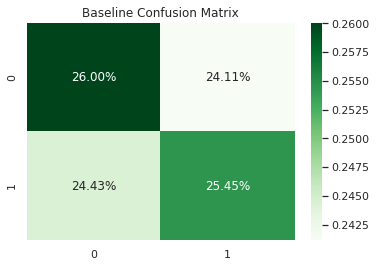

In [ ]:
#Get a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,best_baseline_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Baseline Confusion Matrix')
plt.show()

#Logistic Regression Model

In [ ]:
#Instantiate Models
logistic_model = LogisticRegressionCV(cv=5,max_iter=10000)

#Fit Model
logistic_model.fit(X_scaled_train, y_train)

#Predict on both train and test
y_pred_logistic = logistic_model.predict(X_scaled_test)
y_pred_train_log = logistic_model.predict(X_scaled_train)

#Score Train and Test accuracies
logistic_accuracy = metrics.accuracy_score(y_test,y_pred_logistic)
logistic_accuracy_train = metrics.accuracy_score(y_train,y_pred_train_log)

In [ ]:
#Print out the results
print("Logistic Test Accuracy:", logistic_accuracy)
print("Logistic Train Accuracy:", logistic_accuracy_train)

Logistic Test Accuracy: 0.9330181245074862
Logistic Train Accuracy: 0.9467980295566503


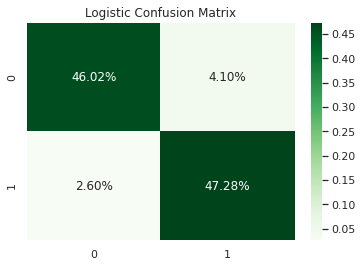

In [ ]:
#Get a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_pred_logistic)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Logistic Confusion Matrix')
plt.show()

In [ ]:
#Store the logistic coefficients
coef = logistic_model.coef_[0]

#Get the names of the columns from one of the X sets
names = X_scaled_train.columns.values

#Create a df with the columns and coefficients to display
df = pd.DataFrame({'column name':names,'coefficient':coef})

#create a new df with the absolute value of the coefficients
df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})

#Sort the coefficients by largest 25 absolute values; maintain sign to see if coef is positive or negative
top_25_logistic_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]

#display top 25 coefficients
top_25_logistic_coefficients

,column name,coefficient,Abs Coef
364,loudness^2,-1.759908,1.759908
77,hollywood,1.290602,1.290602
17,pop,1.259875,1.259875
220,experimental,-1.235353,1.235353
108,chillwave,-1.147547,1.147547
28,country,1.138115,1.138115
5,acousticness,1.086972,1.086972
68,jazz,-0.867379,0.867379
257,filthstep,-0.854312,0.854312
370,energy instrumentalness,-0.847805,0.847805


#Ridge Classification Model

In [ ]:
#Instantiate Ridge Classifier CV across our lambda range
ridge_model = RidgeClassifierCV(cv=5)

#Fit the model
ridge_model.fit(X_scaled_train,y_train)

#Predict on both train and test sets
ridge_yhats = ridge_model.predict(X_scaled_test)
ridge_train_yhats = ridge_model.predict(X_scaled_train)

#Use ridge_model to get the accuracy of the cross-validated model for both sets
ridge_accuracy = metrics.accuracy_score(y_test,ridge_yhats)
ridge_accuracy_train = metrics.accuracy_score(y_train,ridge_train_yhats)

In [ ]:
#Present the results
print("Ridge Test Accuracy:",ridge_accuracy)
print("Ridge Train Accuracy:",ridge_accuracy_train)

Ridge Test Accuracy: 0.9235618597320725
Ridge Train Accuracy: 0.9414778325123153


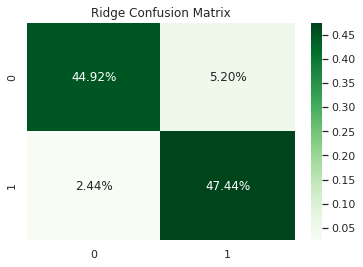

In [ ]:
#Make a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,ridge_model.predict(X_scaled_test))
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Ridge Confusion Matrix')
plt.show()

In [ ]:
#Store the coefficients list in a variable
coef = ridge_model.coef_[0]

#Take names of predictors from our dataframe
names = X_scaled_train.columns.values

#Create a dataframe with names and coefficients to analyze importance
df = pd.DataFrame({'column name':names,'coefficient':coef})

#Also store the absolute values of all variables to see what is most important, regardless of sign
df2 = pd.DataFrame({'Abs Coef':abs(df['coefficient'])})

#Combine dfs so that absolute values and regular coefficients are stored together; take top 25 coefficients to display
top_25_ridge_coefficients=pd.concat([df,df2],axis=1).sort_values(by='Abs Coef',ascending=False)[0:25]

top_25_ridge_coefficients

,column name,coefficient,Abs Coef
6,instrumentalness,-0.885043,0.885043
364,loudness^2,-0.463271,0.463271
2,loudness,0.369389,0.369389
367,loudness instrumentalness,0.348733,0.348733
1,energy,0.268246,0.268246
11,sections,-0.248814,0.248814
331,chorus_hit_percent,0.244311,0.244311
373,instrumentalness^2,0.223678,0.223678
17,pop,0.217016,0.217016
28,country,0.213325,0.213325


#Decision Trees

In [ ]:
#Instantiate
dt = DecisionTreeClassifier(random_state=17)

#Fit
dt.fit(X_scaled_train, y_train)

#predict on both test and train sets
y_hat_tree = dt.predict(X_scaled_test)
y_hat_train_tree = dt.predict(X_scaled_train)

#Check accuracies on test and train sets
tree_acc = metrics.accuracy_score(y_test, y_hat_tree)
tree_train_acc = metrics.accuracy_score(y_train, y_hat_train_tree)

In [ ]:
#Present results 
print('Tree Test Accuracy:',tree_acc)
print('Tree Train Accuracy:',tree_train_acc)

Tree Test Accuracy: 0.8613081166272656
Tree Train Accuracy: 0.9996059113300493


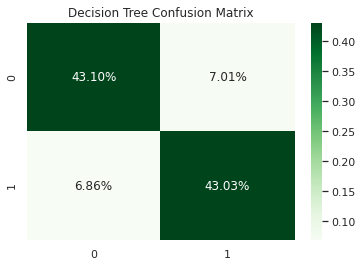

In [ ]:
#Create a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_tree)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Decision Tree Confusion Matrix')
plt.show()

In [ ]:
#Use the feature importance method to get all of the importances in the trees
coef = dt.feature_importances_

#take names for the coefficients from the df
names = X_scaled_train.columns.values

#Make a df with coefficients to measure importances
df = pd.DataFrame({'Column name':names,'Coefficient':coef}).sort_values(by='Coefficient',ascending=False)

#Display top 25 features
top_25_dt_features = df[0:25]

top_25_dt_features

,Column name,Coefficient
6,instrumentalness,0.358464
362,alb_type_compilation,0.056857
17,pop,0.038621
45,metal,0.036153
19,rap,0.030659
150,punk,0.026124
145,worship,0.023672
15,genres_count,0.023177
330,duration_seconds,0.018441
78,filmi,0.017702


In [ ]:
#Instantiate the model
knn_model = KNeighborsClassifier()

#Fit
knn_model.fit(X_scaled_train, y_train)

#predict on both test and train sets
y_hat_knn = knn_model.predict(X_scaled_test)
y_hat_train_knn = knn_model.predict(X_scaled_train)

#Check accuracies on both test and train sets
knn_acc = metrics.accuracy_score(y_test, y_hat_knn)
knn_train_acc = metrics.accuracy_score(y_train, y_hat_train_knn)

In [ ]:
#Present results
print('Test Accuracy:',knn_acc)
print('Train Accuracy:',knn_train_acc)

Test Accuracy: 0.8959810874704491
Train Accuracy: 0.939704433497537


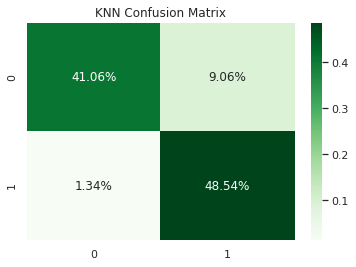

In [ ]:
#Create a confusion matrix using seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_knn)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('KNN Confusion Matrix')
plt.show()

#Random Forest

In [ ]:
#Instantiate
random_forest_model = RandomForestClassifier(random_state=17)

#Fit
random_forest_model.fit(X_scaled_train, y_train)

#predict on both test and training sets
y_hat_rf = random_forest_model.predict(X_scaled_test)
y_hat_rf_train = random_forest_model.predict(X_scaled_train)

#Check accuracies on both test and training sets
rf_acc = metrics.accuracy_score(y_test, y_hat_rf)
rf_train_acc = metrics.accuracy_score(y_train, y_hat_rf_train)

In [ ]:
#Print results
print('Test Accuracy:',rf_acc)
print('Train Accuracy:',rf_train_acc)

Test Accuracy: 0.9109535066981875
Train Accuracy: 0.9996059113300493


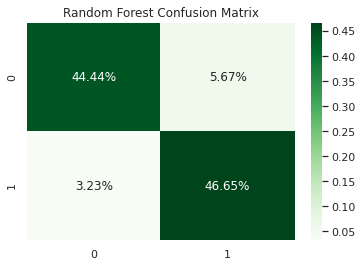

In [ ]:
#Create a confusion matrix in seaborn
matrix = metrics.confusion_matrix(y_test,y_hat_rf)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Random Forest Confusion Matrix')
plt.show()

In [ ]:
#Store random forest importances in a variable
coef = random_forest_model.feature_importances_

#Store names of predictors in a variable
names = X_scaled_train.columns.values

#Create a dataframe with feature importances and sort by importance
df = pd.DataFrame({'Column Name':names,'Feature Importances':coef}).sort_values(by='Feature Importances',ascending=False)

#Select top 25 features to display
top_25_rf_features = df[0:25]

top_25_rf_features

,Column Name,Feature Importances
373,instrumentalness^2,0.097171
367,loudness instrumentalness,0.056803
6,instrumentalness,0.056379
17,pop,0.041275
370,energy instrumentalness,0.039759
372,acousticness instrumentalness,0.031745
19,rap,0.031326
0,danceability,0.029258
364,loudness^2,0.027931
28,country,0.025556


#Bagging

Include hyperparameter justification here

In [ ]:
#Instantiate
bagging_model = BaggingClassifier(random_state=17)

#Fit 
bagging_model.fit(X_scaled_train,y_train)

#Predict on both test and training sets 
bagging_yhat = bagging_model.predict(X_scaled_test)
bagging_yhat_train = bagging_model.predict(X_scaled_train)

#Check accuracies for both sets
best_accuracy_bag = metrics.accuracy_score(y_test,bagging_yhat)
best_accuracy_bag_train = metrics.accuracy_score(y_train,bagging_yhat_train)

In [ ]:
#Present the results
print('Test Accuracy:',best_accuracy_bag)
print('Train Accuracy:',best_accuracy_bag_train)

Test Accuracy: 0.9322301024428684
Train Accuracy: 0.9934975369458128


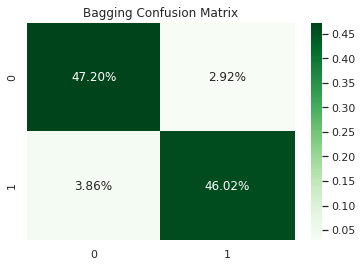

In [ ]:
#Create a confusion matrix and display using seaborn
matrix = metrics.confusion_matrix(y_test,bagging_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Bagging Confusion Matrix')
plt.show()

In [ ]:
#Create a list to store bagging importances
bag_importances = []

#For each estimator in the ensemble, take the individual feature importances and average them to estimate the importance within the ensemble for each feature
for i,x in enumerate(bagging_model.estimators_):

  #Add each estimator to a list to average
  bag_importances.append(bagging_model.estimators_[i].feature_importances_)

#Create a dataframe with all of the importances for each model
bag_importance_df = pd.DataFrame(bag_importances,columns=X_scaled_test.columns)

#Create a dataframe for the top 25 features
top_25_bag_features = pd.DataFrame({'Derived Feature Importance':bag_importance_df.mean().sort_values(ascending=False)})

#Display top 25 features
top_25_bag_features[0:25]

,Derived Feature Importance
instrumentalness,0.179534
loudness instrumentalness,0.149440
pop,0.071799
rap,0.055165
country,0.048892
instrumentalness^2,0.038586
alb_type_compilation,0.038103
metal,0.029679
genres_count,0.021260
punk,0.018018


#Boosting

include justification here for the bounds on each hyperparameter 

In [ ]:
#Instantiate the model
boosted_model = AdaBoostClassifier(random_state=17)

#Fit the model
boosted_model.fit(X_scaled_train,y_train)

#Predict on both the test and training sets
boosted_yhat = boosted_model.predict(X_scaled_test)
boosted_yhat_train = boosted_model.predict(X_scaled_train)

#Check accuracy on both the test and training sets
best_accuracy_boost = metrics.accuracy_score(y_test,boosted_yhat)
best_accuracy_boost_train = metrics.accuracy_score(y_train,boosted_yhat_train)

In [ ]:
#Present the results
print('Best Test Accuracy:',best_accuracy_boost)
print('Best Train Accuracy:',best_accuracy_boost_train)

Best Test Accuracy: 0.9267139479905437
Best Train Accuracy: 0.9324137931034483


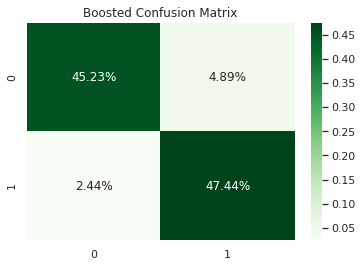

In [ ]:
#Create a confusion matrix and display in seaborn
matrix = metrics.confusion_matrix(y_test,boosted_yhat)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")

plt.title('Boosted Confusion Matrix')
plt.show()

In [ ]:
#Create a list to store the feature importances
boost_importances = []

#Run a loop for every estimator in the ensemble to get feature importances and ultimately average them
for i,x in enumerate(boosted_model.estimators_):

  #Add each set of estimators to the list
  boost_importances.append(boosted_model.estimators_[i].feature_importances_)

#Create a dataframe with the boosting importances and predictor names
boost_importance_df = pd.DataFrame(boost_importances,columns=X_scaled_test.columns)

#Create a dataframe that averages each feature 
top_25_boosted_features = pd.DataFrame({'Derived Feature Importance':boost_importance_df.mean().sort_values(ascending=False)})

#Display top 25 features
top_25_boosted_features[0:25]

,Derived Feature Importance
album_tracks,0.08
instrumentalness,0.06
loudness acousticness,0.04
danceability,0.02
chillstep,0.02
downtempo,0.02
country,0.02
r&b,0.02
afropop,0.02
anti-folk,0.02


#Stacking Classifier

In [ ]:
#Store all baseline estimators in a dictionary to pass into the stacker
estimators =[('bagging', bagging_model),
('rf', random_forest_model),
('boost', boosted_model),
('knn', knn_model),
('logistic', logistic_model),
('ridge', ridge_model),
('dt',dt)]

#Instantiate the stacker on all models
stacked_model = StackingClassifier(estimators=estimators,cv=5)

#Fit the model 
stacked_model.fit(X_scaled_train, y_train)

#Predict on both train and testing sets
yhat_stacked = stacked_model.predict(X_scaled_test)
yhat_stacked_train = stacked_model.predict(X_scaled_train)

#Get scores for both training and testing data
stacked_acc = metrics.accuracy_score(y_test, yhat_stacked)
stacked_acc_train = metrics.accuracy_score(y_train, yhat_stacked_train)

In [ ]:
#Print out the results 
print('Test Accuracy:',stacked_acc)
print('Train Accuracy:',stacked_acc_train)

Test Accuracy: 0.9432624113475178
Train Accuracy: 0.9799014778325124


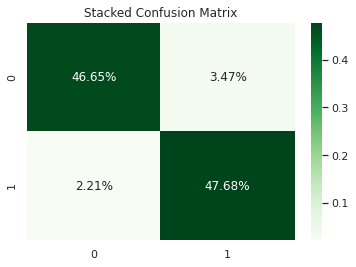

In [ ]:
#Use seaborn to display a confusion matrix
matrix = metrics.confusion_matrix(y_test,yhat_stacked)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%',cmap="Greens")
plt.title('Stacked Confusion Matrix')
plt.show()

#ROC Curve and Model Comparison

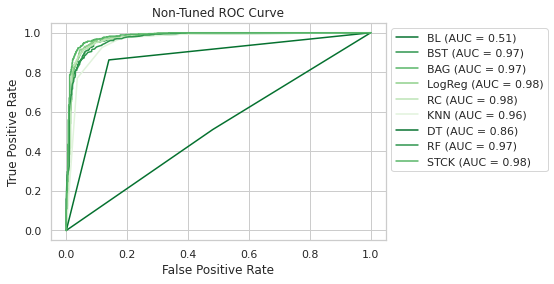

In [ ]:
#List all of the best models
modelset = [best_baseline_model,boosted_model,bagging_model,logistic_model,ridge_model,knn_model,dt,random_forest_model,stacked_model]

model_names = ['BL','BST','BAG','LogReg','RC','KNN','DT','RF','STCK']

#Define the colors for the chart 

sns.set(palette="Greens_r",style='whitegrid')

#Set up the model to stack plots for each classifier

axis = plt.gca()

#iterate through all models

for i,met in enumerate(modelset):
    #Plot the ROC curve for a given model

  metrics.plot_roc_curve(met,X_scaled_test,y_test,ax=axis,name=model_names[i])
 
  #Add legend and title to chart to finish it off

  plt.legend(bbox_to_anchor=(1, 1))
  plt.title('Non-Tuned ROC Curve')
plt.show()

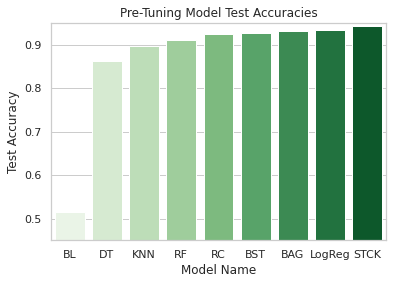

In [ ]:
#Store all accuracy scores for the test set
accuracies= [best_baseline_accuracy,logistic_accuracy,ridge_accuracy,tree_acc,knn_acc,rf_acc,best_accuracy_boost,best_accuracy_bag,stacked_acc]

#Store all accuracies for the training set
train_accuracies = [best_baseline_accuracy_train,logistic_accuracy_train,ridge_accuracy_train,tree_train_acc,knn_train_acc,rf_train_acc,best_accuracy_boost_train,best_accuracy_bag_train,stacked_acc_train]

#Store all names of the classifiers
model_names = ['BL','LogReg','RC','DT','KNN','RF','BST','BAG','STCK']

#Create a dataframe that stores the names and accuracies; sort by test accuracy 
models = pd.DataFrame({'Model Name':model_names,'Test Accuracy':accuracies,'Train Accuracy':train_accuracies}).sort_values(by='Test Accuracy')

#Set the plot palette to spotify green
sns.set(palette="Greens_r",style='whitegrid')

#Create a barplot that shows the test accuracies ranked by name; adjust min and max to be closer to min and max of set 
sns.barplot(y=models['Test Accuracy'],x=models['Model Name'],palette='Greens').set_ylim(.45,.95)

#Add a title
plt.title('Pre-Tuning Model Test Accuracies')
plt.show()

In [ ]:
#Create a new column on the dataframe to show the differences between train/test and understand how much all of our models overfit
models['Difference'] = models['Test Accuracy'] - models['Train Accuracy']

#Sort by test accuracy and display
models = models.sort_values(by='Test Accuracy', ascending=False)
models 

,Model Name,Test Accuracy,Train Accuracy,Difference
8,STCK,0.943262,0.979901,-0.036639
1,LogReg,0.933018,0.946798,-0.013780
7,BAG,0.932230,0.993498,-0.061267
6,BST,0.926714,0.932414,-0.005700
2,RC,0.923562,0.941478,-0.017916
5,RF,0.910954,0.999606,-0.088652
4,KNN,0.895981,0.939704,-0.043723
3,DT,0.861308,0.999606,-0.138298
0,BL,0.514578,0.508177,0.006401
